In [1]:
import torch
from pymonntorch import (
    NeuronGroup,
    NeuronDimension,
    EventRecorder,
    Recorder,
    SynapseGroup,
)
from conex import (
    Neocortex,
    NeuronAxon,
    SpikeTrace,
    SimpleDendriteComputation,
    SimpleDendriteStructure,
    LIF,
)
from conex import (
    Synapsis,
    SynapseInit,
    WeightInitializer,
    Conv2dDendriticInput,
    Conv2dSTDP,
    prioritize_behaviors,
    Fire,
)
from conex import ActivityBaseHomeostasis, KWTA, LateralDendriticInput
from conex.helpers import Poisson
import conex.helpers.filters as filters

from conex.behaviors.synapses import (
    SynapseInit,
    WeightInitializer,
    WeightNormalization,
)

from matplotlib import pyplot as plt

import behaviors.InputData as InputData
from tools.convolutions import convolve, convolve3d, batch_convolve
import tools.readImage as readImage

from plots.model import *

from tools.encode import encode

# Hyperparameters

In [2]:
# input parameters
INPUT_HEIGHT, INPUT_WIDTH = 100, 100

# behavior parameters
RECORDER_INDEX = 460
EV_RECORDER_INDEX = 461

# LIF parameters
OUT_R = 10
OUT_THRESHOLD = 15
OUT_TAU = 3
OUT_V_RESET = 0
OUT_V_REST = 5

# Model parameters
T = 990
f, INPUT_CHANNELS, KERNEL_HEIGHT, KERNEL_WIDTH = 9, 1, INPUT_HEIGHT, INPUT_WIDTH
ACTIVITY_RATE = 0.2
WINDOW_SIZE = 10
K, DIMENSION = 1, 0
I_TAU = 4
LI_D, LI_H, LI_W = f, 5, 5
LI_CURRENT = 1

In [3]:
def prepare_data(
    data_rng=range(1, 10),
    sigma_1=10 / 15,
    sigma_2=3 / 15,
    one_sum=True,
    show_images=False,
    sizes=[3, 7, 11],
):

    size1 = sizes[0]
    f1 = torch.tensor(
        filters.DoGFilter(
            size1, sigma_1=size1 * 10 / 15, sigma_2=size1 * 3 / 15, one_sum=True
        ),
    )
    f1 = f1 / (torch.abs(f1)).max()

    size2 = sizes[1]
    f2 = torch.tensor(
        filters.DoGFilter(
            size2, sigma_1=size2 * 10 / 15, sigma_2=size2 * 3 / 15, one_sum=True
        ),
    )
    f2 = f2 / (torch.abs(f2)).max()

    size3 = sizes[2]
    f3 = torch.tensor(
        filters.DoGFilter(
            size3, sigma_1=size3 * 10 / 15, sigma_2=size3 * 3 / 15, one_sum=True
        ),
    )
    f3 = f3 / (torch.abs(f3)).max()

    temp = [
        convolve(
            f"0{i}.png",
            # useTorch=True,
            prefix="./images/",
            n=INPUT_HEIGHT,
            show_image=show_images,
            filter=filter,
            flatten=True,
            return_both=True,
        )
        for filter in [f1, f2, f3]
        for i in data_rng
    ]
    data = []
    for d in temp:
        data += d

    return {
        "data": data,
        "parameters": [
            {
                f"f{size1}_size": size1,
                f"f{size1}_sigma_1": size1 * 10 / 15,
                f"f{size1}_sigma_2": size1 * 3 / 15,
            },
            {
                f"f{size2}_size": size2,
                f"f{size2}_sigma_1": size2 * 10 / 15,
                f"f{size2}_sigma_2": size2 * 3 / 15,
            },
            {
                f"f{size3}_size": size3,
                f"f{size3}_sigma_1": size3 * 10 / 15,
                f"f{size3}_sigma_2": size3 * 3 / 15,
            },
        ],
    }

In [4]:
data, temp_parameters = prepare_data(
    show_images=False, data_rng=range(1, f + 1)
).values()
parameters = []
for d in temp_parameters:
    for item in d:
        parameters.append(f"{item}: {d[item]}")
print(parameters)

/var/folders/58/7wqv58ns32s3g7d1404b7mmw0000gn/T/ipykernel_17772/3001344719.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f1 = torch.tensor(
/var/folders/58/7wqv58ns32s3g7d1404b7mmw0000gn/T/ipykernel_17772/3001344719.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f2 = torch.tensor(
/var/folders/58/7wqv58ns32s3g7d1404b7mmw0000gn/T/ipykernel_17772/3001344719.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f3 = torch.tensor(


['f3_size: 3', 'f3_sigma_1: 2.0', 'f3_sigma_2: 0.6', 'f7_size: 7', 'f7_sigma_1: 4.666666666666667', 'f7_sigma_2: 1.4', 'f11_size: 11', 'f11_sigma_1: 7.333333333333333', 'f11_sigma_2: 2.2']


In [5]:
data, temp_parameters = prepare_data(
    show_images=False, data_rng=range(1, f + 1), sizes=[3, 5, 7]
).values()
parameters = []
for d in temp_parameters:
    for item in d:
        parameters.append(f"{item}: {d[item]}")
print(parameters)

/var/folders/58/7wqv58ns32s3g7d1404b7mmw0000gn/T/ipykernel_17772/3001344719.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f1 = torch.tensor(
/var/folders/58/7wqv58ns32s3g7d1404b7mmw0000gn/T/ipykernel_17772/3001344719.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f2 = torch.tensor(
/var/folders/58/7wqv58ns32s3g7d1404b7mmw0000gn/T/ipykernel_17772/3001344719.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f3 = torch.tensor(


['f3_size: 3', 'f3_sigma_1: 2.0', 'f3_sigma_2: 0.6', 'f5_size: 5', 'f5_sigma_1: 3.3333333333333335', 'f5_sigma_2: 1.0', 'f7_size: 7', 'f7_sigma_1: 4.666666666666667', 'f7_sigma_2: 1.4']


In [6]:
print(parameters)

['f3_size: 3', 'f3_sigma_1: 2.0', 'f3_sigma_2: 0.6', 'f5_size: 5', 'f5_sigma_1: 3.3333333333333335', 'f5_sigma_2: 1.0', 'f7_size: 7', 'f7_sigma_1: 4.666666666666667', 'f7_sigma_2: 1.4']


In [7]:
import plots.gifMaker as gif


def train(
    data,
    height=INPUT_HEIGHT,
    width=INPUT_WIDTH,
    iterations=T,
    OUT_R=OUT_R,
    OUT_THRESHOLD=OUT_THRESHOLD,
    OUT_TAU=OUT_TAU,
    OUT_V_RESET=OUT_V_RESET,
    OUT_V_REST=OUT_V_REST,
    input_channels=INPUT_CHANNELS,
    kernel_height=KERNEL_HEIGHT,
    kernel_width=KERNEL_WIDTH,
    f=f,
    activity_rate=ACTIVITY_RATE,
    window_siz=WINDOW_SIZE,
    encode_method="ITL",
    show_weights=True,
    show_last_spike=True,
    show_mean_spike=True,
    show_result_spike=True,
    show_activity=False,
    feature_gif_skip_frame=10,
    print_convolution_result=True,
    rest_time=10,
    weight_mode="ones",
    AP=2,
    AM=1,
    K=K,
    s=0.1,
):

    layer2_height, layer2_width = (
        height - kernel_height + 1,
        width - kernel_width + 1,
    )
    net = Neocortex(dt=1, device="cpu", dtype=torch.float32)
    ng1 = NeuronGroup(
        size=NeuronDimension(height=height, width=width),
        behavior={
            **prioritize_behaviors(
                [
                    SimpleDendriteStructure(),
                    SimpleDendriteComputation(),
                    LIF(
                        R=OUT_R,
                        threshold=OUT_THRESHOLD,
                        tau=OUT_TAU,
                        v_reset=OUT_V_RESET,
                        v_rest=OUT_V_REST,
                    ),  # 260
                    Fire(),  # 340
                    SpikeTrace(tau_s=3),
                    NeuronAxon(),
                ]
            ),
            **{
                10: InputData.ResetMemory(),
                345: InputData.Encode(
                    data=torch.tensor(data),
                    # range=255,
                    time=window_siz,
                    sparsity=1,
                    input_period=window_siz + rest_time,
                    ratio=0.05,
                    method=encode_method,
                ),
                # 350: act.Activity(),
                RECORDER_INDEX: Recorder(
                    variables=["v", "I"],
                    tag="in_recorder",
                ),
                EV_RECORDER_INDEX: EventRecorder("spikes", tag="in_ev_recorder"),
            },
        },
        net=net,
    )

    ng2 = NeuronGroup(
        size=NeuronDimension(depth=f, height=layer2_height, width=layer2_width),
        net=net,
        behavior={
            **prioritize_behaviors(
                [
                    SimpleDendriteStructure(),
                    SimpleDendriteComputation(),
                    LIF(
                        tau=10,
                        v_rest=0,
                        v_reset=0,
                        threshold=1,
                        R=1,
                    ),
                    KWTA(k=K, dimension=0),
                    Fire(),
                    SpikeTrace(tau_s=10.0),
                    NeuronAxon(),
                    # ActivityBaseHomeostasis(
                    #     activity_rate=activity_rate * window_siz,
                    #     window_size=(window_siz + rest_time)*f,
                    #     updating_rate=0.1,
                    #     decay_rate=0.2,
                    # ),
                    ActivityBaseHomeostasis(
                        activity_rate=activity_rate * window_siz,
                        window_size=(window_siz + rest_time),
                        updating_rate=0.1,
                    ),
                ]
            ),
            **{
                RECORDER_INDEX: Recorder(variables=["spikes"], tag="out_recorder"),
                EV_RECORDER_INDEX: EventRecorder(
                    variables=["I", "spikes"], tag="out_ev_recorder"
                ),
            },
        },
    )
    synapse_input_layer2 = Synapsis(
        net=net,
        src=ng1,
        dst=ng2,
        synaptic_tag="Proximal",
        synapsis_behavior={
            **prioritize_behaviors(
                [
                    SynapseInit(),
                    WeightNormalization(),
                    WeightInitializer(
                        mode=weight_mode,
                        scale=5,
                        weight_shape=(f, input_channels, kernel_height, kernel_width),
                        kernel_shape=(f, input_channels, kernel_height, kernel_width),
                    ),
                    Conv2dDendriticInput(
                        # current_coef=1 * (kernel_height * kernel_width)
                        current_coef= 20,
                    ),
                    Conv2dSTDP(
                        a_plus=AP * (kernel_height * kernel_width),
                        a_minus=AM * (kernel_height * kernel_width),
                        w_max=2 / (kernel_height * kernel_width),
                        positive_bound="soft_bound",
                        negative_bound="soft_bound",
                    ),
                ]
            ),
            **{
                RECORDER_INDEX: Recorder(tag="synapse_recorder", variables=["weights"]),
            },
        },
    )

    lateral_inhibition = Synapsis(
        net=net,
        src=ng2,
        dst=ng2,
        synaptic_tag="Proximal",
        synapsis_behavior=prioritize_behaviors(
            [
                SynapseInit(),
                WeightInitializer(
                    mode="ones",
                    scale=0.5,
                    weight_shape=(1, 1, 2 * f + 1, 1, 1),
                    kernel_shape=(1, 1, 2 * f + 1, 1, 1),
                ),
                LateralDendriticInput(inhibitory=True, current_coef=1000),
            ]
        ),
    )
    net.initialize(info=False)
    net.simulate_iterations(iterations)
    spikes = ng2.spikes.reshape(f, layer2_height, layer2_width)
    # spikes = ng2.spikes
    if show_activity:
        plt.scatter(
            ng1["in_ev_recorder", 0].variables["spikes"][:, 0].cpu(),
            ng1["in_ev_recorder", 0].variables["spikes"][:, 1].cpu(),
            s=s,
        )
        plt.title("input activity")
        plt.show()

        plt.scatter(
            ng2["out_ev_recorder", 0].variables["spikes"][:, 0].cpu(),
            ng2["out_ev_recorder", 0].variables["spikes"][:, 1].cpu(),
            s=s,
        )
        plt.title("output activity")

        plt.show()

    # print (synapse_input_layer2.weights.shape)
    if show_weights:
        plot_grid(
            synapse_input_layer2.synapses[0].weights.reshape(
                f, kernel_height, kernel_width
            ),
            f=f,
        )
        
    if feature_gif_skip_frame:
        print(
            synapse_input_layer2.synapses[0][RECORDER_INDEX, 0]
            .variables["weights"]
            .shape
        )
        weights = (
            synapse_input_layer2.synapses[0][RECORDER_INDEX, 0]
            .variables["weights"]
            .reshape(iterations, f, kernel_height, kernel_width)
        )
        gif.generate(
            weights,
            skip_frame=feature_gif_skip_frame,
            title=f"Features {kernel_height}*{kernel_width}",
        )

        spikes = (
            ng2[RECORDER_INDEX, 0]
            .variables["spikes"]
            .reshape(iterations, f, layer2_height, layer2_width)
        )
        gif.generate(
            spikes,
            skip_frame=feature_gif_skip_frame,
            title=f"Spikes {kernel_height}*{kernel_width}",
        )

    if show_last_spike:
        spikes = ng2.spikes.reshape(f, layer2_height, layer2_width)
        plot_grid(spikes, f=f, title="Last spikes")

    if show_mean_spike:
        spikes = (
            ng2[RECORDER_INDEX, 0]
            .variables["spikes"]
            .reshape(iterations, f, layer2_height, layer2_width)
        )
        spikes = spikes.sum(axis=0, keepdim=True)[0]
        plot_grid(spikes, f=f, title="Mean of spikes")
    if show_result_spike:
        for i in range(f):

            spikes = (
                ng2[RECORDER_INDEX, 0]
                .variables["spikes"]
                .reshape(iterations, f, layer2_height, layer2_width)[
                    -(window_siz + rest_time) * (i + 1) : -(window_siz + rest_time) * i
                ]
            )
            spikes = spikes.sum(axis=0, keepdim=True)[0]
            plot_grid(spikes, f=f, title="Spiking Convolution Result")

    return net

2xBatch: 1/1 (100%) 71.393ms


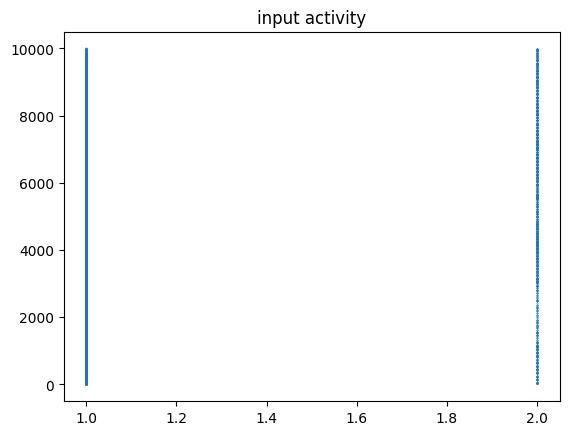

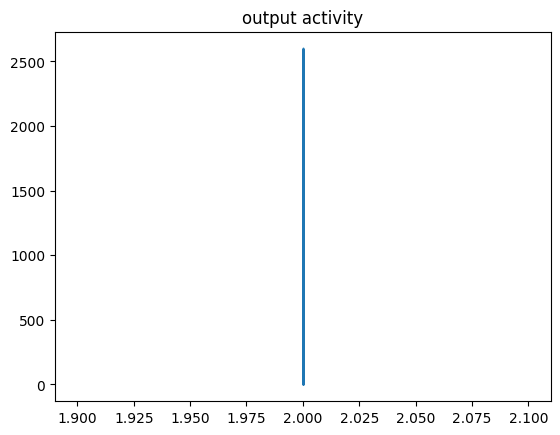

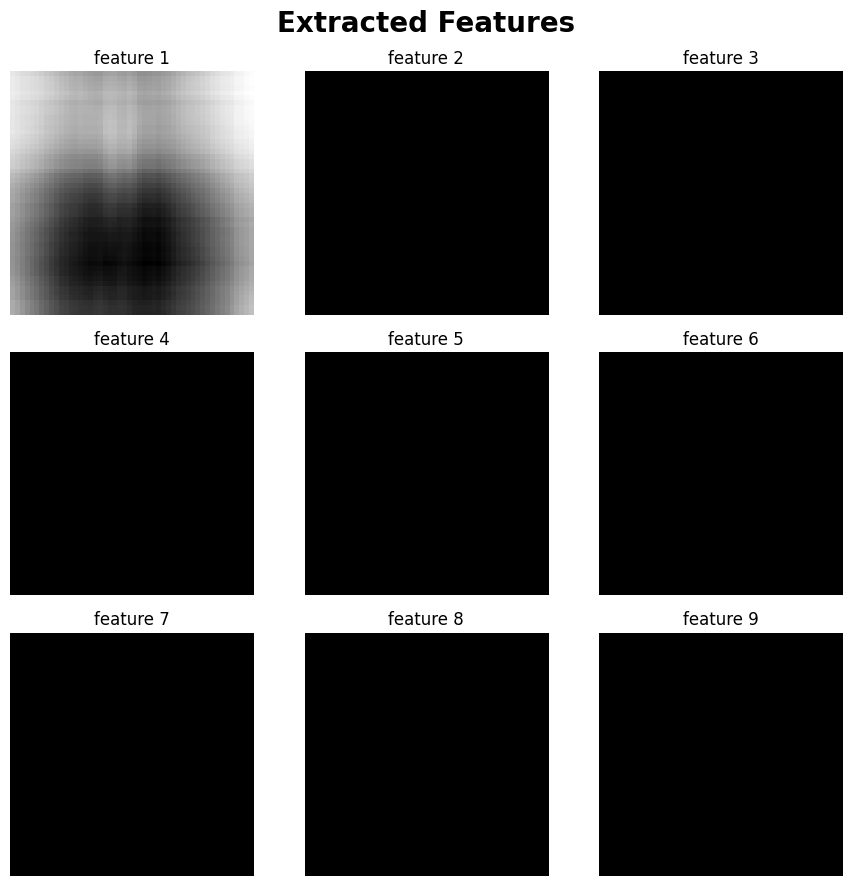

In [22]:
net = train(
    data,
    iterations=3,
    rest_time=1,
    window_siz=2,
    activity_rate=0.1,
    show_last_spike=False,
    show_mean_spike=False,
    show_result_spike=False,
    print_convolution_result=False,
    show_activity=True,
    feature_gif_skip_frame=0,
    AP=0.02,
    AM=0.01,
)

In [9]:
# net = train(
#     data,
#     iterations=1000,
#     rest_time=0,
#     window_siz=5,
#     activity_rate=1,
#     show_last_spike=False,
#     show_mean_spike=False,
#     feature_gif_skip_frame=0,
#     AP=0.02,
#     AM=0.01,
# )

In [10]:
# net = train(
#     data,
#     iterations=1000,
#     activity_rate=0.3,
#     feature_gif_skip_frame=0,
#     show_last_spike=False,
#     show_mean_spike=False,
#     AP=0.01,
#     AM=0.01,
# )

In [11]:
# net = train(
#     data,
#     iterations=1000,
#     feature_gif_skip_frame=0,
#     rest_time=0,
#     window_siz=5,
#     kernel_height=9,
#     kernel_width=9,
#     activity_rate=0.1,
#     AP=1,
# )

In [12]:
# net = train(
#     data,
#     iterations=1000,
#     feature_gif_skip_frame=0,
#     rest_time=0,
#     window_siz=10,
#     kernel_height=9,
#     kernel_width=9,
#     activity_rate=1,
#     AM=1,
#     AP=1,
# )

In [13]:
# net = train(
#     data,
#     iterations=1000,
#     rest_time=1,
#     window_siz=2,
#     feature_gif_skip_frame=0,
#     kernel_height=7,
#     kernel_width=7,
#     activity_rate=0.1,
# )

In [14]:
net2 = train(
    data,
    iterations=1000,
    activity_rate=0.2,
    rest_time=2,
    window_siz=2,
    feature_gif_skip_frame=50,
    show_result_spike=False,
    show_last_spike=False,
    show_mean_spike=False,
    AP=0.2,
    AM=0.1,
)

|||| 100  |||| 200  |||| 300  |||| 400  |||| 500  |||| 600  |||| 700  |||| 800  |||| 900  ||

KeyboardInterrupt: 

In [ ]:
net2 = train(
    data,
    iterations=1000,
    activity_rate=0.2,
    rest_time=5,
    window_siz=2,
    kernel_height=21,
    kernel_width=21,
    feature_gif_skip_frame=10,
    show_last_spike=False,
    show_mean_spike=False,
    AP=2,
    AM=1,
)

|||| 100  

KeyboardInterrupt: 

In [ ]:
net2 = train(
    data,
    iterations=1000,
    activity_rate=0.2,
    rest_time=5,
    window_siz=2,
    kernel_height=15,
    kernel_width=15,
    feature_gif_skip_frame=10,
    show_last_spike=False,
    show_mean_spike=False,
    AP=2,
    AM=1,
)

In [ ]:
net2 = train(
    data,
    iterations=1000,
    activity_rate=0.2,
    rest_time=5,
    window_siz=2,
    kernel_height=11,
    kernel_width=11,
    feature_gif_skip_frame=10,
    show_last_spike=False,
    show_mean_spike=False,
    AP=2,
    AM=1,
)

In [ ]:
net2 = train(
    data,
    iterations=1000,
    activity_rate=0.2,
    rest_time=5,
    window_siz=2,
    kernel_height=5,
    kernel_width=5,
    feature_gif_skip_frame=10,
    show_last_spike=False,
    show_mean_spike=False,
    AP=2,
    AM=1,
)

In [ ]:
# net2 = train(
#     data,
#     iterations=1000,
#     activity_rate=0.2,
#     rest_time=5,
#     window_siz=2,
#     kernel_height=21,
#     kernel_width=21,
#     feature_gif_skip_frame=10,
#     show_last_spike=False,
#     show_mean_spike=False,
#     AP=2,
#     AM=1,
# )

In [ ]:
net = train(
    data,
    iterations=1000,
    window_siz=2,
    rest_time=1,
    activity_rate=0.1,
    show_last_spike=False,
    show_mean_spike=False,
    show_result_spike=False,
    feature_gif_skip_frame=0,
    AP=0.2,
    AM=0.01,
)

In [ ]:
net2 = train(
    data,
    iterations=1000,
    activity_rate=0.2,
    rest_time=5,
    window_siz=2,
    kernel_height=35,
    kernel_width=35,
    feature_gif_skip_frame=10,
    show_last_spike=False,
    show_mean_spike=False,
    AP=2,
    AM=1,
)